In [1]:
import os
import sys

from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.local import LocalQuantumJob
from braket.jobs.image_uris import Framework, retrieve_image
from qiskit_braket_provider.providers import adapter
from braket.circuits import Gate, Instruction, Circuit

aws_session = AwsSession(default_bucket="amazon-braket-us-west-1-lukasvoss")

module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from needed_files.quantumenvironment import QuantumEnvironment
from needed_files.helper_functions import load_agent_from_yaml_file
from needed_files.ppo import make_train_ppo
from needed_files.q_env_config import q_env_config as gate_q_env_config

import time

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(
I0000 00:00:1706510993.338264       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
q_env = QuantumEnvironment(gate_q_env_config)

SparsePauliOp(['II', 'IY', 'XI', 'XY'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


##### Parametrized qiskit circuit

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


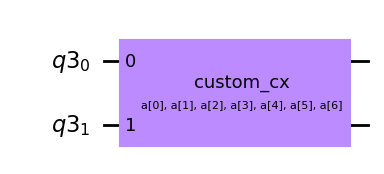

In [3]:
qiskit_circuit = q_env.circuit_truncations[0]
qiskit_circuit.draw(output='mpl')

#### Convert the qiskit circuit to a braket circuit

In [4]:
braket_circuit = adapter.convert_qiskit_to_braket_circuit(qiskit_circuit)

In [5]:
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.parametervector import ParameterVectorElement
import numpy as np

In [6]:
q_reg = QuantumRegister(2)
params = ParameterVector(name='a', length=7)

In [7]:
my_qc = QuantumCircuit(q_reg, name="custom_cx")
optimal_params = np.pi * np.zeros(7)

my_qc.u(
    optimal_params[0] + params[0],
    optimal_params[1] + params[1],
    optimal_params[2] + params[2],
    q_reg[0],
)
my_qc.u(
    optimal_params[3] + params[3],
    optimal_params[4] + params[4],
    optimal_params[5] + params[5],
    q_reg[1],
)
my_qc.rzx(optimal_params[6] + params[6], q_reg[0], q_reg[1])

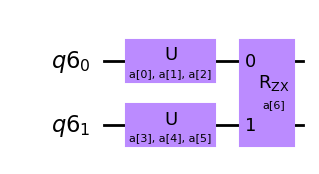

In [8]:
my_qc.draw(output='mpl')

In [9]:
braket_circuit = adapter.convert_qiskit_to_braket_circuit(my_qc)

In [10]:
print(braket_circuit)

T  : |     0     |   1    |     2     |3|4|   5    |6|7|
                                                        
q0 : -PHASE(a[2])-Ry(a[0])-PHASE(a[1])---C----------C---
                                         |          |   
q1 : -PHASE(a[5])-Ry(a[3])-PHASE(a[4])-H-X-Rz(a[6])-X-H-

T  : |     0     |   1    |     2     |3|4|   5    |6|7|

Unassigned parameters: [a[0], a[1], a[2], a[3], a[4], a[5], a[6]].


In [11]:
moments = braket_circuit.moments
list_instructions = []
for key, value in moments.items():
    #print(key)
    print(value, "\n")
    list_instructions.append(value)

Instruction('operator': PhaseShift('angle': a[2], 'qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1) 

Instruction('operator': Ry('angle': a[0], 'qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1) 

Instruction('operator': PhaseShift('angle': a[1], 'qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1) 

Instruction('operator': PhaseShift('angle': a[5], 'qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1) 

Instruction('operator': Ry('angle': a[3], 'qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1) 

Instruction('operator': PhaseShift('angle': a[4], 'qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1) 

Instruction('operator': H('qubit_count': 1), 'targ

In [12]:
new_circ = Circuit()
new_circ.moments.add(list_instructions)
print(new_circ, "\n")
print(new_circ == braket_circuit)

T  : |     0     |   1    |     2     |3|4|   5    |6|7|
                                                        
q0 : -PHASE(a[2])-Ry(a[0])-PHASE(a[1])---C----------C---
                                         |          |   
q1 : -PHASE(a[5])-Ry(a[3])-PHASE(a[4])-H-X-Rz(a[6])-X-H-

T  : |     0     |   1    |     2     |3|4|   5    |6|7| 

True
